In [34]:
import numpy as np
import modin.pandas as mipd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
import gc
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [35]:
# technical nets are unweighted
def get_tech_net(path):

    bipartite_G = nx.Graph()
    df = pd.read_csv(path, header=None, sep='##', engine='python')
    df.columns = ['file', 'dev', 'weight']

    ## Logic to add nodes and edges to graph with their metadata
    for _, row in df.iterrows():
        dev_node = row['dev']
        file_node = row['file'].replace('   (with props)', '')
        bipartite_G.add_node(dev_node, bipartite='dev')
        bipartite_G.add_node(file_node, bipartite='file')
        bipartite_G.add_edge(dev_node, file_node)

    dev_nodes = {n for n, d in bipartite_G.nodes(data=True) if d["bipartite"] == 'dev'}
    file_nodes = {n for n, d in bipartite_G.nodes(data=True) if d["bipartite"] == 'file'}
    
    return bipartite_G
def cal_tech_net(path):
    # check if file does not exist or empty
    if not os.path.exists(path) or os.stat(path).st_size == 0:
        return {'t_num_dev_nodes':0,\
                't_num_file_nodes':0,\
                't_num_dev_per_file':0,\
                't_num_file_per_dev':0,\
                't_graph_density':0,\
                't_dev_nodes': set()}

    bipartite_G = get_tech_net(path)

    graph_density = bipartite.density(bipartite_G, dev_nodes)
    file_degrees, dev_degrees = bipartite.degrees(bipartite_G, dev_nodes)

    num_file_nodes = len(file_degrees)
    num_dev_nodes = len(dev_degrees)
    file_node_degree = sum([degree for node, degree in file_degrees])/len(file_degrees)
    dev_node_degree = sum([degree for node, degree in dev_degrees])/len(dev_degrees)

    # return the features of tech net
    return {'t_num_dev_nodes':num_dev_nodes,\
            't_num_file_nodes':num_file_nodes,\
            't_num_dev_per_file':file_node_degree,\
            't_num_file_per_dev':dev_node_degree,\
            't_graph_density':graph_density,\
            't_dev_nodes': set(dev_nodes)}

def get_social_net(path):
    G = nx.read_edgelist(path, create_using=nx.DiGraph(), nodetype=str, comments='*', delimiter='##', data=(('weight', int),))
    return G

# social nets are weighted
def cal_social_net(path):
    # if no network data
    if not os.path.exists(path) or os.stat(path).st_size == 0:
        return {'s_num_nodes':0, \
                's_dev_nodes':set(),\
                's_weighted_mean_degree':0,\
                's_num_component':0,\
                's_avg_clustering_coef':0,\
                's_largest_component':0,\
                's_graph_density':0}

    # Processing features in social networks
    G = nx.read_edgelist(path, create_using=nx.DiGraph(), nodetype=str, comments='*', delimiter='##', data=(('weight', int),))
    # all dev nodes
    dev_nodes = set(G.nodes)
    # num. of total nodes
    num_nodes = len(dev_nodes)
    # weighted mean degree
    degrees = G.degree(weight='weight')
    weighted_mean_degree = sum([degree for node, degree in degrees])/num_nodes
    # average clustering coefficient
    avg_clustering_coef = nx.average_clustering(G)
    # betweenness = nx.betweenness_centrality(G, weight='weight')
    graph_density = nx.density(G)

    G = nx.read_edgelist(path, create_using=nx.Graph(), nodetype=str, comments='*', delimiter='##', data=(('weight', int),))
    # num. of dis-connected components
    num_component = nx.number_connected_components(G)
    # largest connected component
    largest_component = len(max(nx.connected_components(G), key=len))
    # num. of nodes in each component
    # num_nodes_component = [list(c) for c in list(nx.connected_components(G))]

    # return the features of the 
    return {'s_num_nodes': num_nodes,\
            's_dev_nodes': dev_nodes,\
            's_weighted_mean_degree':weighted_mean_degree,\
            's_num_component':num_component,\
            's_avg_clustering_coef':avg_clustering_coef,\
            's_largest_component':largest_component,\
            's_graph_density':graph_density}

In [36]:
def get_num_edges(file_name):
    if not os.path.exists(file_name):
        return -1
    with open(file_name, "r") as f:
        lines = f.read().splitlines()
    return len(lines)

# Overlap Calculation

In [37]:
## Overlap Calculation now:
def sets_jaccard_unweighted(net1_set, net2_set):
    intersection_edges = net1_set.intersection(net2_set)
    return len(intersection_edges) / (len(net1_set) + len(net2_set)-len(intersection_edges))

def sets_overlap_unweighted(net1_set, net2_set):
    intersection_edges = net1_set.intersection(net2_set)
    return len(intersection_edges) / min([len(net1_set), len(net2_set)])

In [38]:
# Overlap calculation from Likang
# Jaccard Now
def get_net_overlap(net1, net2):
	
	if not os.path.exists(net1):
		return 0
	if not os.path.exists(net2):
		return 0

	net1_set = set()
	with open(net1, 'r') as f:
		lines = f.read().splitlines()
	# print([net1, net2])
	for line in lines:
		sender, recivier, weight = line.split('##')
		net1_set.add((sender, recivier))
	net2_set = set()
	with open(net2, 'r') as f:
		lines = f.read().splitlines()
	for line in lines:
		sender, recivier, weight = line.split('##')		
		net2_set.add((sender, recivier))
	if len(net1_set) == 0 or len(net2_set) == 0:
		return 0

	return sets_overlap_unweighted(net1_set, net2_set)
	#return sets_jaccard_unweighted(net1_set, net2_set)

In [39]:
# Overlap calculation from Likang
# Jaccard Now
def get_net_jaccard(net1, net2):
	
	if not os.path.exists(net1):
		return 0
	if not os.path.exists(net2):
		return 0

	net1_set = set()
	with open(net1, 'r') as f:
		lines = f.read().splitlines()
	# print([net1, net2])
	for line in lines:
		sender, recivier, weight = line.split('##')
		net1_set.add((sender, recivier))
	net2_set = set()
	with open(net2, 'r') as f:
		lines = f.read().splitlines()
	for line in lines:
		sender, recivier, weight = line.split('##')		
		net2_set.add((sender, recivier))
	if len(net1_set) == 0 or len(net2_set) == 0:
		return 0

	#return sets_overlap_unweighted(net1_set, net2_set)
	return sets_jaccard_unweighted(net1_set, net2_set)

In [40]:
def g_unite(net_tech, net_social, net_mix):
	# Merge tech network and social network by edgelist files
	if not os.path.exists(net_tech):
		return None
	if not os.path.exists(net_social):
		return None

	net1_set = []
	with open(net_tech, 'r') as f:
		lines = f.read().splitlines()
	# print([net1, net2])
	for line in lines:
		sender, recivier, weight = line.split('##')
		net1_set.append([recivier, sender, weight])
	net2_set = []
	with open(net_social, 'r') as f:
		lines = f.read().splitlines()
	for line in lines:
		sender, recivier, weight = line.split('##')		
		net1_set.append([sender, recivier, weight])

	#print(net_mix_set)
	with open(net_mix, 'w') as f:
		for sender, recivier, weight in net1_set:
			f.write(sender+"##"+recivier+"##"+weight+"\n")


	return net1_set

In [41]:
### Faster
time_resolution = 30
time_window = 7

c_path = '../network_data_smoothed'+str(time_resolution+time_window)+'/commits/'
e_path = '../network_data_smoothed'+str(time_resolution+time_window)+'/emails/'
#c_path = './network_data/commits/'

projects = os.listdir(c_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)

project_names = pd.Series(project_names).drop_duplicates().values
project_freqs.describe()

count     4315
unique     258
top       wave
freq        59
dtype: object

In [42]:
projects = os.listdir(c_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)

df_tech_lens = pd.DataFrame()
the_path = c_path
for projid in tqdm(project_freqs.drop_duplicates().to_list()):
    lens = []
    prev_fname = the_path+projid+'__'+str(0)+".edgelist"
    for seq_num in range(1,100):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        lens.append(get_num_edges(this_fname))

    projname = str(projid).lower()
    #print(projname)
    df_tech_lens[projname] = pd.Series(lens) 
df_tech_lens.to_csv("../result_csv/tech_edgesize_smoothed"+str(time_resolution+time_window)+".csv", index=None, sep=',')
    

100%|██████████| 258/258 [00:00<00:00, 537.46it/s]


In [43]:
projects = os.listdir(e_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)

df_social_lens = pd.DataFrame()
the_path = e_path
for projid in tqdm(project_freqs.drop_duplicates().to_list()):
    lens = []
    prev_fname = the_path+projid+'__'+str(0)+".edgelist"
    for seq_num in range(1,100):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        lens.append(get_num_edges(this_fname))

    projname = str(projid).lower()
    #print(projname)
    df_social_lens[projname] = pd.Series(lens) 
df_social_lens.to_csv("../result_csv/social_edgesize_smoothed"+str(time_resolution+time_window)+".csv", index=None, sep=',')
    

100%|██████████| 272/272 [00:00<00:00, 843.79it/s]


In [44]:
projects = os.listdir(c_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)

df_tech_overlaps = pd.DataFrame()
the_path = c_path
for projid in tqdm(project_freqs.drop_duplicates().to_list()):
    overlaps = []
    prev_fname = the_path+projid+'__'+str(0)+".edgelist"
    for seq_num in range(1,100):
        #seq_num = 1
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        
        #while os.path.exists(this_fname):
        if os.path.exists(prev_fname):
            overlaps.append(get_net_overlap(prev_fname, this_fname))
        #seq_num+=1
        prev_fname = this_fname
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        
    overlaps.append(-1.0)
    for i in range(len(overlaps),100):
        overlaps.append(-1.0)
    projname = str(projid).lower()
    #print(projname)
    df_tech_overlaps[projname] = pd.Series(overlaps) 
df_tech_overlaps.to_csv("../result_csv/tech_overlaps_smoothed"+str(time_resolution+time_window)+".csv", index=None, sep=',')
    

100%|██████████| 258/258 [00:02<00:00, 106.95it/s]


In [45]:
projects = os.listdir(e_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)

df_tech_overlaps = pd.DataFrame()
the_path = e_path
for projid in tqdm(project_freqs.drop_duplicates().to_list()):
    overlaps = []
    prev_fname = the_path+projid+'__'+str(0)+".edgelist"
    for seq_num in range(1,100):
        #seq_num = 1
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        
        #while os.path.exists(this_fname):
        if os.path.exists(prev_fname):
            overlaps.append(get_net_overlap(prev_fname, this_fname))
        #seq_num+=1
        prev_fname = this_fname
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        
    overlaps.append(-1.0)
    for i in range(len(overlaps),100):
        overlaps.append(-1.0)
    projname = str(projid).lower()
    #print(projname)
    df_tech_overlaps[projname] = pd.Series(overlaps) 
df_tech_overlaps.to_csv("../result_csv/social_overlaps_smoothed"+str(time_resolution+time_window)+".csv", index=None, sep=',')
    

100%|██████████| 272/272 [00:00<00:00, 361.74it/s]


In [46]:
df_tech_overlaps = pd.read_csv("../result_csv/tech_overlaps_smoothed"+str(time_resolution+time_window)+".csv")
df_social_overlaps = pd.read_csv("../result_csv/social_overlaps_smoothed"+str(time_resolution+time_window)+".csv")
df_tech_edgesize = pd.read_csv("../result_csv/tech_edgesize_smoothed"+str(time_resolution+time_window)+".csv")
df_social_edgesize = pd.read_csv("../result_csv/social_edgesize_smoothed"+str(time_resolution+time_window)+".csv")

all_graduated = np.load('../all_graduated.npy').tolist()
#all_graduated = [x.lower() for x in all_graduated]
all_retired = np.load('../all_retired.npy').tolist()
#all_retired = [x.lower() for x in all_retired]

all_graduated = [x.lower() for x in all_graduated if x.lower() in df_tech_overlaps.columns and x.lower() in df_social_overlaps.columns]
all_retired = [x.lower() for x in all_retired if x.lower() in df_tech_overlaps.columns and x.lower() in df_social_overlaps.columns]

In [47]:
df_tech_overlaps.columns

Index(['openwebbeans', 'jena', 'shindig', 'sanselan', 'skywalking', 'stdcxx',
       'wave', 'tajo', 'ratis', 'mrunit',
       ...
       'muse', 'chemistry', 'beehive', 'reef', 'cayenne', 'zipkin', 'ofbiz',
       'subversion', 'ibatis', 'cmda'],
      dtype='object', length=258)

In [48]:
def remove_minus(list):
    while -1.0 in list :
        list.remove(-1.0)
    return list

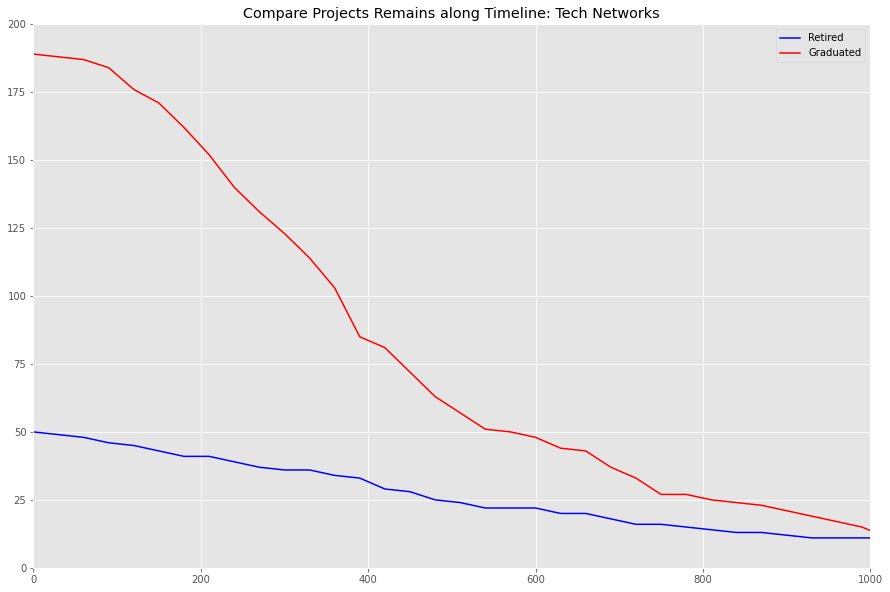

In [49]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_tech_edgesize.index))]
count = [0 for i in range(len(df_tech_edgesize.index))]

for col in all_retired:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
d1 = count[:i]

plt.plot(x,d1,color = 'b', label = "Retired")


ave = [0 for i in range(len(df_tech_edgesize.index))]
count = [0 for i in range(len(df_tech_edgesize.index))]

for col in all_graduated:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
d2 = count[:i]

plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Remains along Timeline: Tech Networks")
plt.xlim(0,1000)
plt.ylim(0,200)
#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

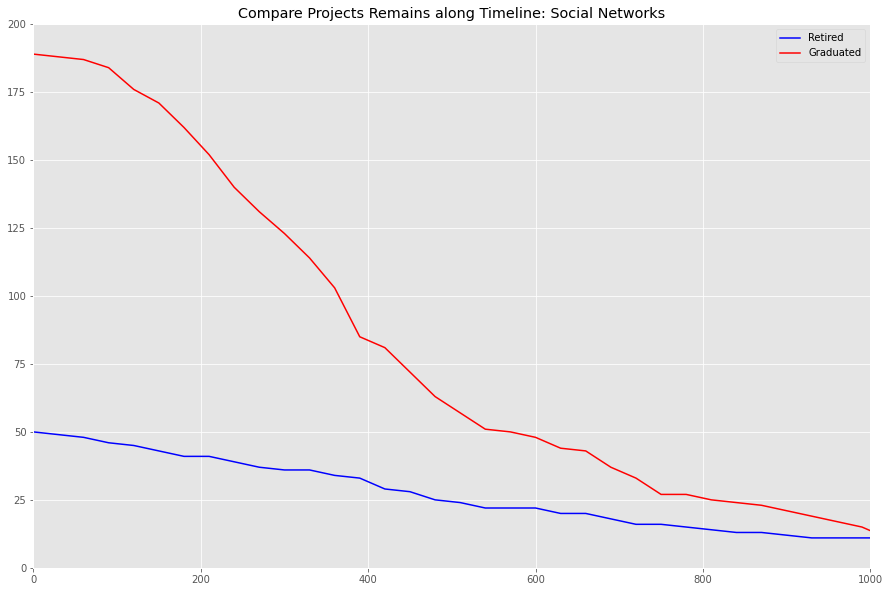

In [50]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_social_edgesize.index))]
count = [0 for i in range(len(df_social_edgesize.index))]

for col in all_retired:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
d1 = count[:i]

plt.plot(x,d1,color = 'b', label = "Retired")


ave = [0 for i in range(len(df_social_edgesize.index))]
count = [0 for i in range(len(df_social_edgesize.index))]

for col in all_graduated:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
d2 = count[:i]

plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Remains along Timeline: Social Networks")
plt.xlim(0,1000)
plt.ylim(0,200)
#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

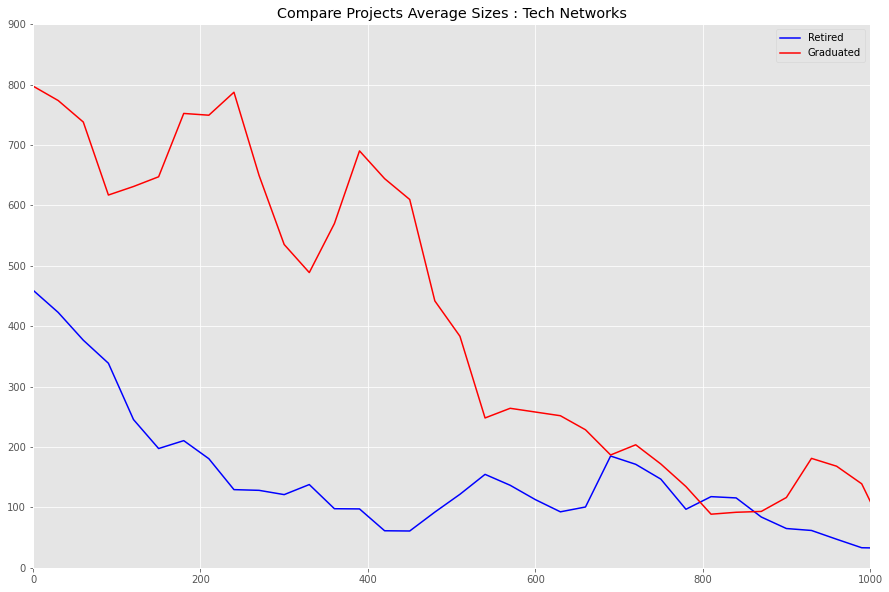

In [51]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_tech_edgesize.index))]
count = [0 for i in range(len(df_tech_edgesize.index))]

for col in all_retired:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
#d1 = ave[:i]
d1 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d1,color = 'b', label = "Retired")


ave = [0 for i in range(len(df_tech_edgesize.index))]
count = [0 for i in range(len(df_tech_edgesize.index))]

for col in all_graduated:
    data = df_tech_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
#d2 = ave[:i]
d2 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Average Sizes : Tech Networks")
plt.xlim(0,1000)
plt.ylim(0,900)
#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

In [52]:
### Tech network sizes
df_tech_edgesize_graduated = df_tech_edgesize[all_graduated]
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t_graduated = []
labels_time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
for time in labels_time:
    data_thistime = df_tech_edgesize_graduated.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t_graduated.append(data_thistime)



#plt.boxplot(datas_t, labels=labels_time, patch_artist= True, boxprops={'color':'orangered', 'facecolor':'pink'})
df_tech_edgesize_retired = pd.DataFrame()
for col in all_retired:
    if col not in df_tech_edgesize.columns:
        continue
    df_tech_edgesize_retired[col] = df_tech_edgesize[col]

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t_retired = []
labels_time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
#for i in range(len(labels_time)):
#    labels_time[i]+=1
print(labels_time)
for time in labels_time:
    data_thistime = df_tech_edgesize_retired.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t_retired.append(data_thistime)


df = pd.DataFrame({'Time':[x*time_resolution for x in labels_time],\
                  'Graduated':datas_t_graduated,'Retired':datas_t_retired})
#plt.boxplot(datas_t, labels=labels_time, patch_artist= True, boxprops={'color':'lightblue', 'facecolor':'lightgreen'})
df = df[['Time','Graduated','Retired']]

#plt.title("Compare Projects Average Overlap : social Networks")

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Compare Projects Size: Tech Networks')

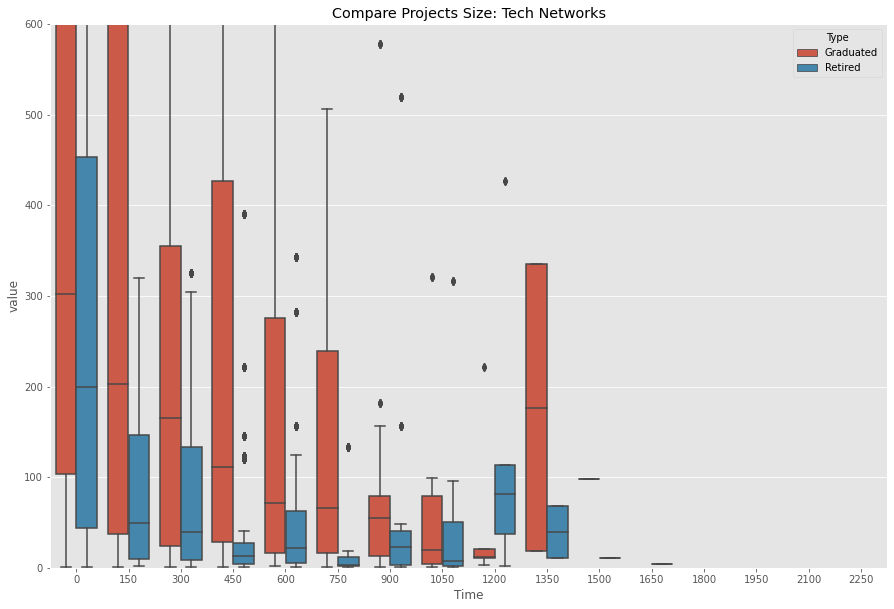

In [53]:
df = df.explode("Graduated")
df = df.explode("Retired")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

dd=pd.melt(df,id_vars=['Time'],value_vars=['Graduated','Retired'],var_name='Type')
sns.boxplot(x='Time',y='value',data=dd,hue='Type')

plt.ylim(0,600)
plt.title("Compare Projects Size: Tech Networks")

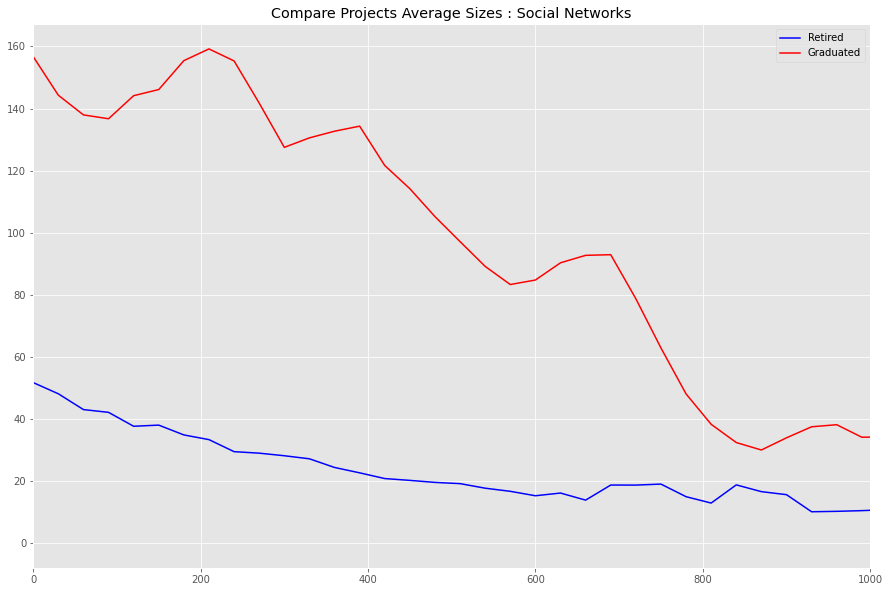

In [54]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_social_edgesize.index))]
count = [0 for i in range(len(df_social_edgesize.index))]

for col in all_retired:
    data = df_social_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
#d1 = ave[:i]
d1 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d1,color = 'b', label = "Retired")


ave = [0 for i in range(len(df_social_edgesize.index))]
count = [0 for i in range(len(df_social_edgesize.index))]

for col in all_graduated:
    data = df_social_edgesize[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = [x*time_resolution for x in range(len(ave[:i]))]
#d2 = ave[:i]
d2 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Average Sizes : Social Networks")
plt.xlim(0,1000)
#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

In [55]:
### social network sizes
df_social_edgesize_graduated = df_social_edgesize[all_graduated]
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t_graduated = []
labels_time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
for time in labels_time:
    data_thistime = df_social_edgesize_graduated.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t_graduated.append(data_thistime)



#plt.boxplot(datas_t, labels=labels_time, patch_artist= True, boxprops={'color':'orangered', 'facecolor':'pink'})
df_social_edgesize_retired = pd.DataFrame()
for col in all_retired:
    if col not in df_social_edgesize.columns:
        continue
    df_social_edgesize_retired[col] = df_social_edgesize[col]

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t_retired = []
labels_time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
#for i in range(len(labels_time)):
#    labels_time[i]+=1
print(labels_time)
for time in labels_time:
    data_thistime = df_social_edgesize_retired.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t_retired.append(data_thistime)


df = pd.DataFrame({'Time':[x*time_resolution for x in labels_time],\
                  'Graduated':datas_t_graduated,'Retired':datas_t_retired})
#plt.boxplot(datas_t, labels=labels_time, patch_artist= True, boxprops={'color':'lightblue', 'facecolor':'lightgreen'})
df = df[['Time','Graduated','Retired']]

#plt.title("Compare Projects Average Overlap : social Networks")

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Compare Projects Size: Social Networks')

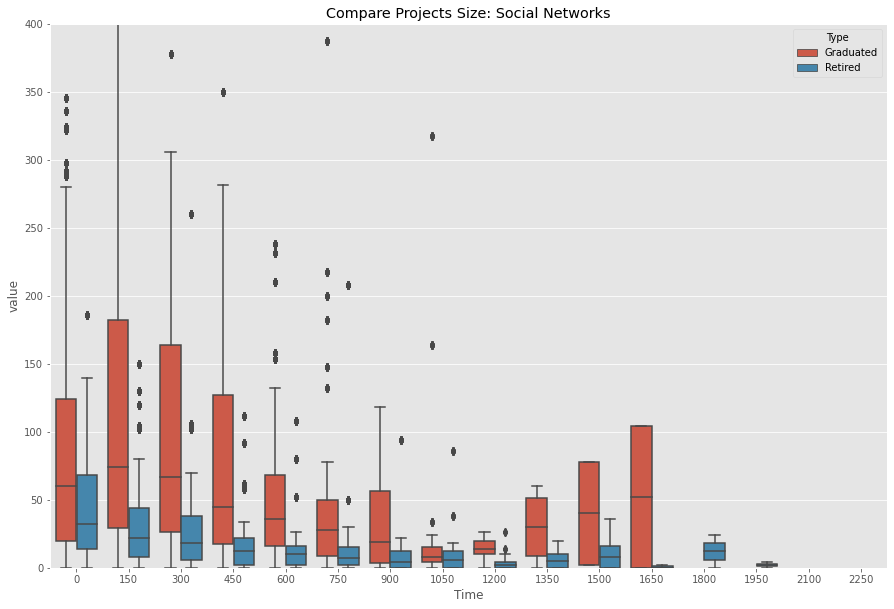

In [56]:
df = df.explode("Graduated")
df = df.explode("Retired")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

dd=pd.melt(df,id_vars=['Time'],value_vars=['Graduated','Retired'],var_name='Type')
sns.boxplot(x='Time',y='value',data=dd,hue='Type')

plt.ylim(0,400)
plt.title("Compare Projects Size: Social Networks")

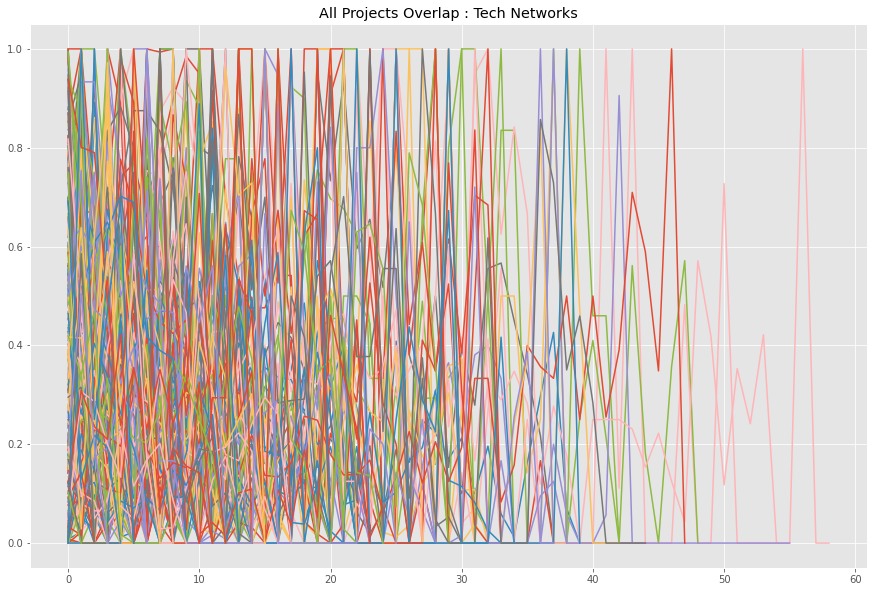

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

for col in df_tech_overlaps.columns:
    data = df_tech_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
    #print(data[:i])

    x = range(len(data[:i]))

    plt.plot(x,data[:i])
    plt.title("All Projects Overlap : Tech Networks")
    

<BarContainer object of 59 artists>

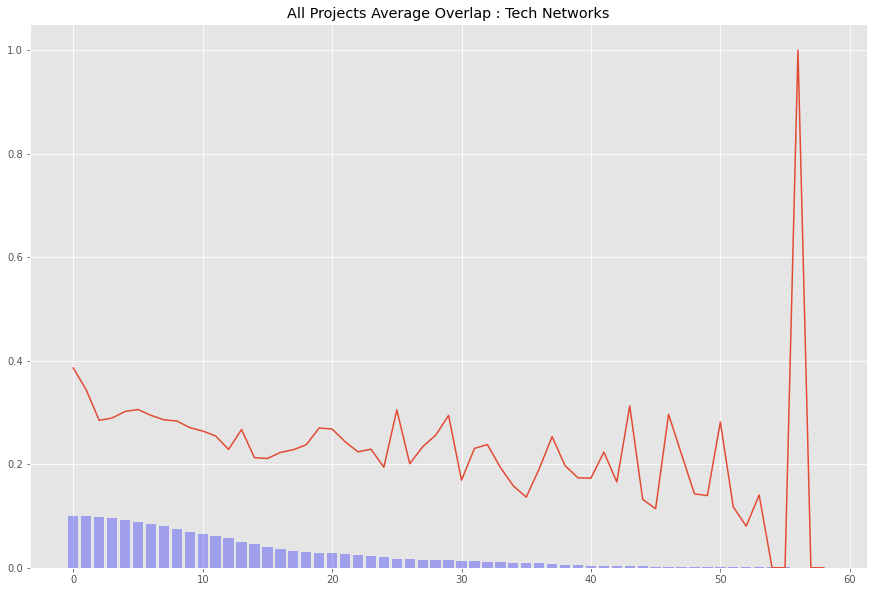

In [58]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_tech_overlaps.index))]
count = [0 for i in range(len(df_tech_overlaps.index))]

for col in df_tech_overlaps.columns:
    data = df_tech_overlaps[col.lower()].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))

plt.plot(x,ave[:i])

plt.title("All Projects Average Overlap : Tech Networks")

#print(ave)
#print(count)
len(df_tech_overlaps.loc[0].values)
plt.bar(x,np.array(count[:i])/len(df_tech_overlaps.columns)/10, fc='b', alpha=0.3)
#plt.boxplot([df_tech_overlaps.loc[0].values], label=[0])

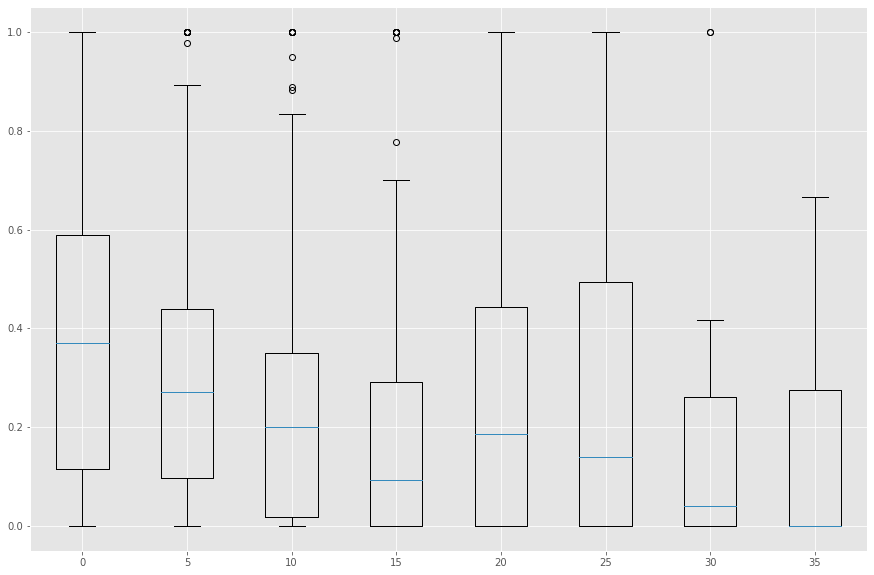

In [59]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t = []
labels_time = [0,5,10,15,20,25,30,35]
for time in labels_time:
    data_thistime = df_tech_overlaps.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t.append(data_thistime)




plt.boxplot(datas_t, labels=labels_time)
plt.show()

<BarContainer object of 60 artists>

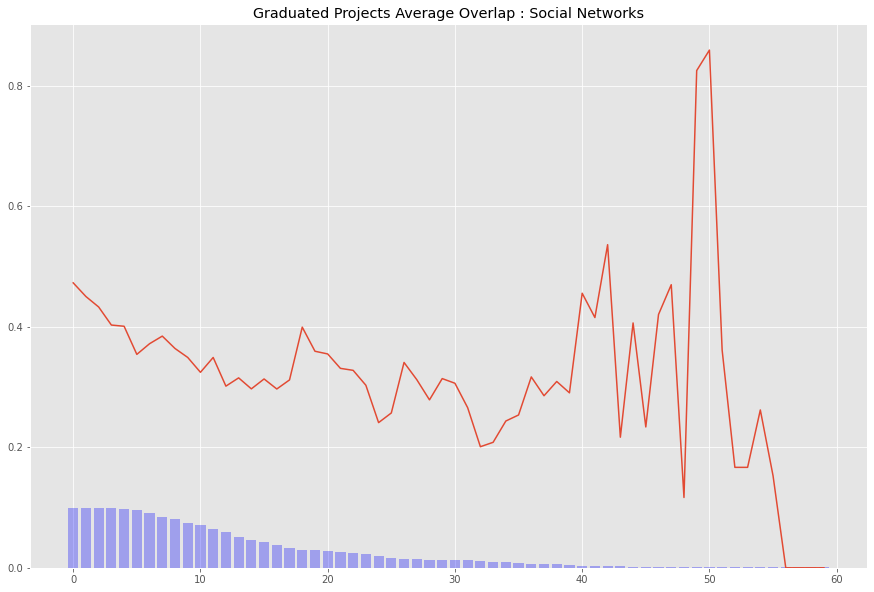

In [60]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]
for col in all_graduated:
    if col.lower() not in df_social_overlaps.columns :
        continue
    data = df_social_overlaps[col.lower()].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))

plt.plot(x,ave[:i])
plt.title("Graduated Projects Average Overlap : Social Networks")

plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
#print(ave)
#print(count)

Text(0.5, 1.0, 'Graduated Projects Average Overlap : Tech Networks')

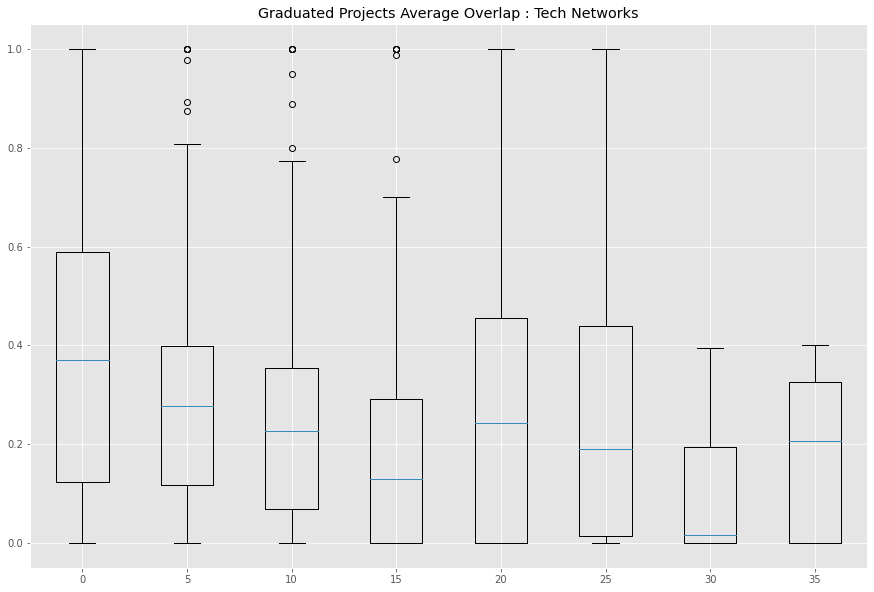

In [61]:
df_tech_overlaps_graduated = df_tech_overlaps[[x.lower() for x in all_graduated if x.lower() in df_tech_overlaps.columns ]]
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

#count = count[:20]
#plt.bar(range(20),np.array(count)/265)
datas_t = []
labels_time = [0,5,10,15,20,25,30,35]
for time in labels_time:
    data_thistime = df_tech_overlaps_graduated.loc[time].values.tolist()
    data_thistime = remove_minus(data_thistime)
    datas_t.append(data_thistime)



plt.boxplot(datas_t, labels=labels_time)
plt.title("Graduated Projects Average Overlap : Tech Networks")

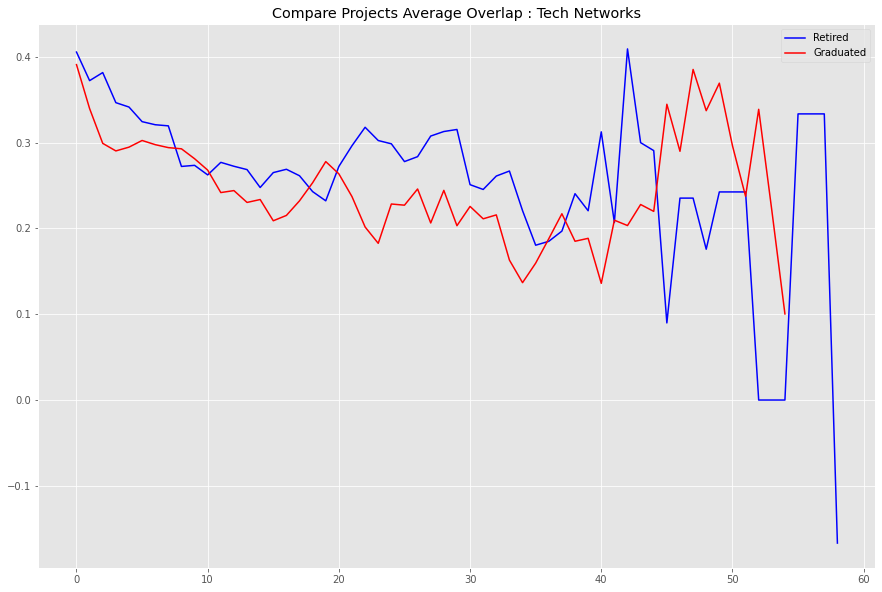

In [62]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_tech_overlaps.index))]
count = [0 for i in range(len(df_tech_overlaps.index))]

for col in all_retired:
    data = df_tech_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))
#d1 = ave[:i]
d1 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d1,color = 'b', label = "Retired")


ave = [0 for i in range(len(df_tech_overlaps.index))]
count = [0 for i in range(len(df_tech_overlaps.index))]

for col in all_graduated:
    data = df_tech_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))
#d2 = ave[:i]
d2 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Average Overlap : Tech Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

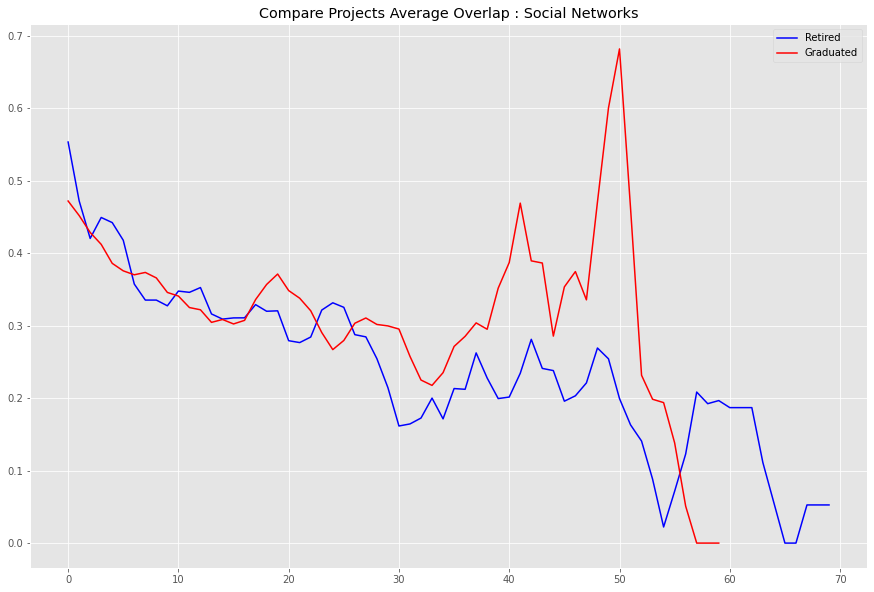

In [63]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [0 for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in all_retired:
    if col not in df_social_overlaps.columns:
        continue
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(ave)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))
#d1 = ave[:i]
d1 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d1,color = 'b', label = "Retired")



ave = [0 for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in all_graduated:
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave [i]+= data[i]
        count[i]+=1
for i in range(len(ave)):
    if count[i]==0:
        break
    ave[i] = ave[i]/count[i]
    #print(data[:i])

x = range(len(ave[:i]))
#d2 = ave[:i]
d2 = savgol_filter(ave[:i], 3, 1)
plt.plot(x,d2,color = 'r', label = 'Graduated')
plt.title("Compare Projects Average Overlap : Social Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')

Pearsons correlation: 0.343
Pearsons correlation After Smoothed: 0.727


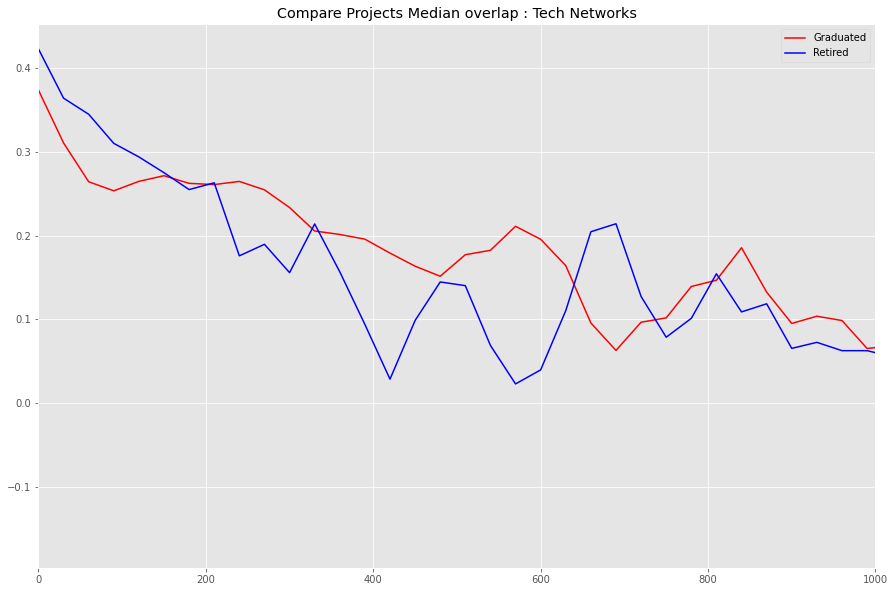

In [64]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_tech_overlaps.index))]
count = [0 for i in range(len(df_tech_overlaps.index))]

for col in all_graduated:
    data = df_tech_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d1 = ave[:j]
data1 = d1[:36]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

all_r = list()
for x in all_retired:
    if x in df_tech_overlaps.columns:
        all_r.append(x)

ave = [[] for i in range(len(df_tech_overlaps.index))]
count = [0 for i in range(len(df_tech_overlaps.index))]

for col in all_r:
    data = df_tech_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d2 = ave[:j]
data2 = d2[:36]
from scipy.signal import savgol_filter
d2 = savgol_filter(ave[:j], 3, 1)
plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median overlap : Tech Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 1000)

from scipy.stats import pearsonr
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(d1[:36], d2[:36])
print('Pearsons correlation After Smoothed: %.3f' % corr)

Pearsons correlation: 0.690
Pearsons correlation After Smoothed: 0.813


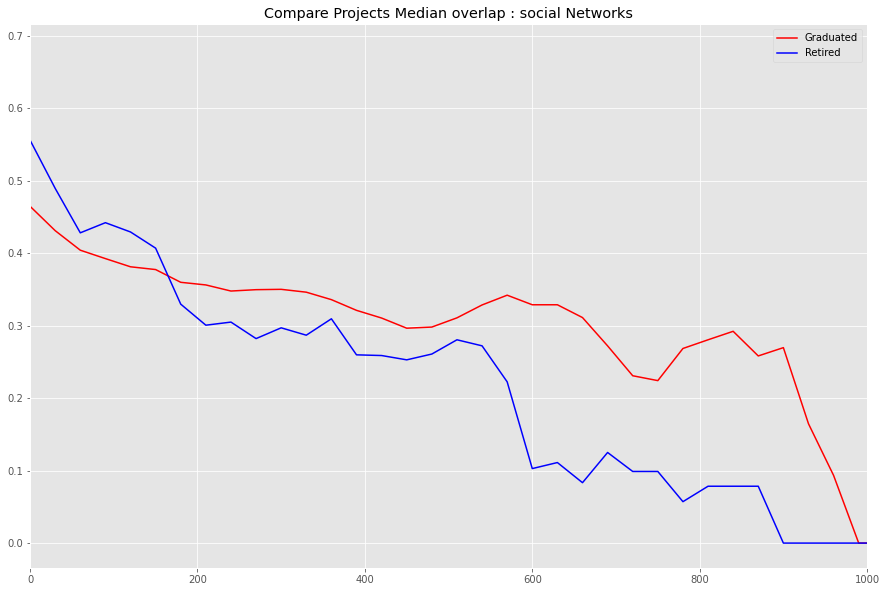

In [65]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in all_graduated:
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d1 = ave[:j]
data1 = d1[:36]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

all_r = list()
for x in all_retired:
    if x in df_social_overlaps.columns:
        all_r.append(x)

ave = [[] for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in all_r:
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d2 = ave[:j]
data2 = d2[:36]
from scipy.signal import savgol_filter
# Smoothed or not smoothed, it is a question
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median overlap : social Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 1000)

from scipy.stats import pearsonr
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(d1[:36], d2[:36])
print('Pearsons correlation After Smoothed: %.3f' % corr)

In [66]:
gc.collect()

40486

(0.0, 0.5)

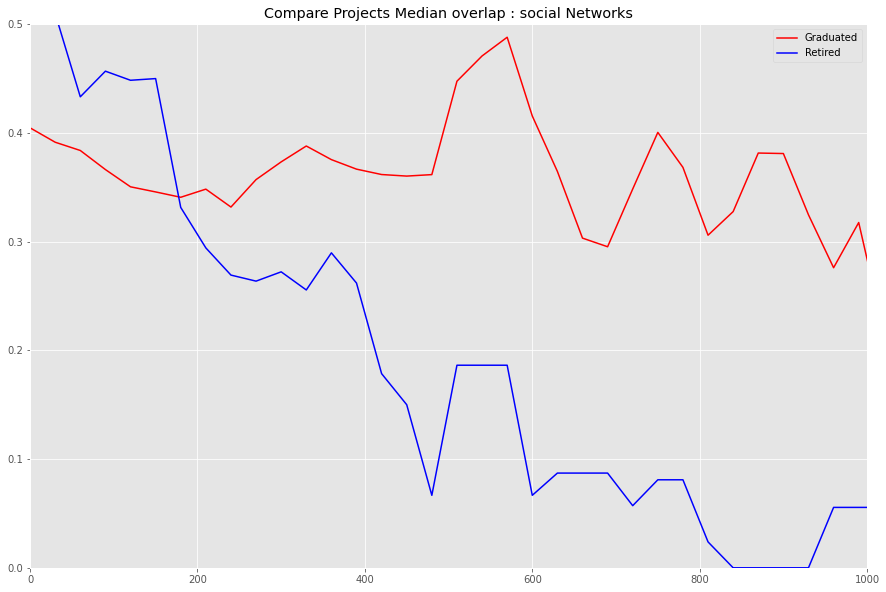

In [67]:
from sklearn.utils.random import sample_without_replacement
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in [all_graduated[x] for x in sample_without_replacement(len(all_graduated), 25)]:
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d1 = ave[:j]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

all_r = list()
for x in all_retired:
    if x in df_social_overlaps.columns:
        all_r.append(x)

ave = [[] for i in range(len(df_social_overlaps.index))]
count = [0 for i in range(len(df_social_overlaps.index))]

for col in [all_r[x] for x in sample_without_replacement(len(all_r), 25)]:
    data = df_social_overlaps[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*time_resolution for x in range(len(ave[:j]))]
d2 = ave[:j]
from scipy.signal import savgol_filter
# Smoothed or not smoothed, it is a question
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median overlap : social Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 1000)
plt.ylim(0, 0.5)